## 🚀 Inference Notebook Strategy for Kaggle Competitions

For Kaggle competitions that involve models with long training times, like deep learning models for image classification, the best practice is to separate your workflow into two distinct notebooks:

---

### 1. **Training Notebook**

This notebook is where you'll do all the heavy lifting of training your model.  
[Cassava Leaf train using EfficientNetB3 fine tuning](https://www.kaggle.com/code/amirmohamadaskari/cassava-leaf-train-efficientnetb3-fine-tuning/edit)

* It should leverage powerful accelerators like **TPUs** or **GPUs** to speed up the training process.
* Once your model is trained, you'll **save the trained model file** (e.g., as a `.keras` or `SavedModel` format) to your notebook's output directory.
* After the training is complete and the model is saved, you then **save a version** of this notebook. The output of this notebook (your trained model) becomes a permanent asset on Kaggle.

---

### 2. **Inference Notebook (This Notebook)**

This notebook is designed specifically for making predictions and generating your submission file. It's built to be lightweight and fast.

* It **doesn't perform any training**. Instead, it **loads the pre-trained model** that you saved as an output from your Training Notebook. To do this, you'll add the Training Notebook's output as an **input dataset** to this Inference Notebook.
* It then focuses solely on **loading the test data**, using the loaded model to make predictions, and **formatting these predictions into the required `submission.csv` file**.
* This separation ensures that your submission run is quick and reliable, as it doesn't need to re-train the model every time. Kaggle's submission system will run this entire notebook to generate your final submission.

In [1]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import random

2025-12-10 15:46:35.053366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765381595.392904      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765381595.483310      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Some configuration based on training
AUTO = tf.data.AUTOTUNE
IMAGE_SIZE = (512, 512)
BATCH_SIZE_PER_REPLICA = 8
NUM_CLASSES = 5
BATCH_SIZE = 8

These two lines define **key file paths** for your Kaggle notebook:

---

* **`DATA_DIR = '/kaggle/input/cassava-leaf-disease-classification'`**
    This points to the **competition's dataset**, which Kaggle automatically makes available in the `/kaggle/input/` directory. It's where your notebook finds the images and other data it needs.

---

* **`MODEL_DIR = '/kaggle/input/cassava-leaf-model/tensorflow2/default/1/final_model_cassava.keras'`**
    This specifies the location of your **trained model file**. On Kaggle, if you train a model in one notebook and want to use it in another (like an inference notebook), you save the training notebook, and its output (your model) can then be added as an **input dataset** to your current notebook. This makes the model accessible via the `/kaggle/input/` path.

In [3]:
DATA_DIR = '/kaggle/input/cassava-leaf-disease-classification'
MODEL_DIR = '/kaggle/input/cassava-leaf-model/tensorflow2/default/1/final_model_cassava.keras'

## Loading model

Let's load our model.  
I saved my model from training script. 
**Note**: Always save models is good approach cause somehow we can't import output of older versions of our notebook as input. so I uploaded there and use it for inference but main approach that I explained doesn't change at all:      
[Cassava Leaf Model](https://www.kaggle.com/models/amirmohamadaskari/cassava-leaf-model)

In [4]:
model = load_model(MODEL_DIR)

I0000 00:00:1765381623.423530      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## 🔍 Inference on Test Set

With our model trained and fine-tuned, it's time to generate predictions on the unseen test data. We'll first create a data pipeline for the test set, similar to the one we built for training and validation.

In [6]:
# This function decodes examples from the test TFRecord files.
# Note that test files contain an 'image_name' instead of a 'target' label.
def decode_test_example(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'image_name': tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, feature_description)
    
    # Decode and process the image
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    
    # Return the image and its ID
    return image, example['image_name']

In [7]:
from tensorflow.keras.applications.efficientnet import preprocess_input

def preprocess(image, label):
    # Apply the specific preprocessing required by the EfficientNet model
    image = preprocess_input(image)
    return image, label

### Test-Time Augmentation (TTA)

To potentially improve our prediction accuracy, we will use **Test-Time Augmentation (TTA)**. This technique involves creating multiple augmented versions of each test image, making a prediction for each version, and then averaging these predictions. This process can lead to more robust and accurate results as it reduces the impact of random variations in the test images.

In [8]:
data_augmentation = tf.keras.Sequential([
    # Geometric Transformations
    tf.keras.layers.RandomRotation(40/ 360), # Randomly rotate images
    tf.keras.layers.RandomTranslation(0.2, 0.2), # Randomly shift images horizontally and vertically
    tf.keras.layers.RandomZoom(0.2, 0.2), # Randomly zoom into images
    tf.keras.layers.RandomFlip('horizontal'), # Randomly flip images horizontally
    tf.keras.layers.RandomFlip('vertical') # Randomly flip images vertically
], name="data_augmentation")

In [9]:
# Create the test dataset pipeline
TEST_DIR = os.path.join(DATA_DIR, 'test_tfrecords')
test_files = tf.io.gfile.glob(os.path.join(TEST_DIR, '*.tfrec'))
test_dataset = tf.data.TFRecordDataset(test_files, num_parallel_reads= AUTO)
test_dataset = (test_dataset
                .map(decode_test_example, num_parallel_calls= AUTO)
                .map(lambda image, image_id: (preprocess_input(image), image_id), num_parallel_calls= AUTO)
                .batch(BATCH_SIZE)
                .prefetch(AUTO))

print('Test dataset created Successfully !')

Test dataset created Successfully !


In [10]:
# Function to get TTA predictions for a full batch of images
def tta_predict_batch(model, images, ids, num_tta):
    """
    Run Test-Time Augmentation (TTA) on a batch of images.

    Args:
        model: Trained keras model
        images: Batch of test images
        ids: Batch of image ids (filenames)
        num_tta: Number of augmentations per image

    Returns:
        preds: Averaged predictions for this batch
        names: List of image ids corresponding to preds
    """
    all_preds = []

    for _ in range(num_tta):
        # Apply augmentation to the *whole batch*
        augmented = data_augmentation(images, training=True)

        # Preprocess for EfficientNet
        preprocessed = preprocess_input(augmented)

        # Run inference on GPU (much faster in batch mode)
        preds = model.predict(preprocessed, verbose=1)

        all_preds.append(preds)

    # Average predictions across TTA rounds
    mean_preds = np.mean(all_preds, axis=0)

    # Convert ids from tf.Tensors to python strings
    names = [img_id.numpy().decode("utf-8") for img_id in ids]

    return mean_preds, names


Loading 6 training images for inference check...
Running TTA (5 augmentations per image)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


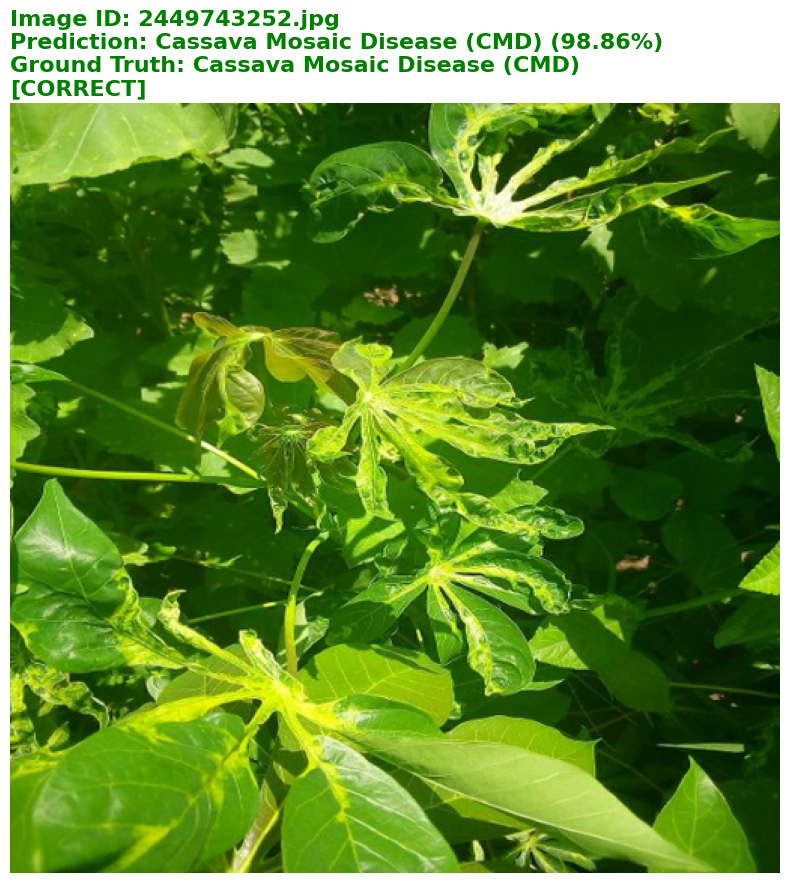

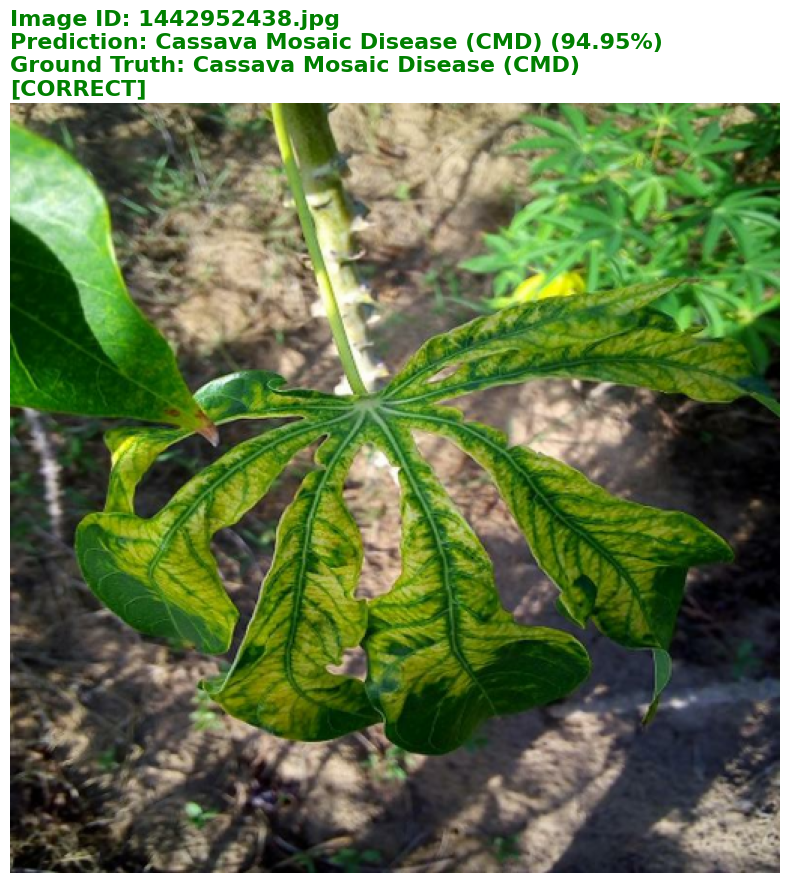

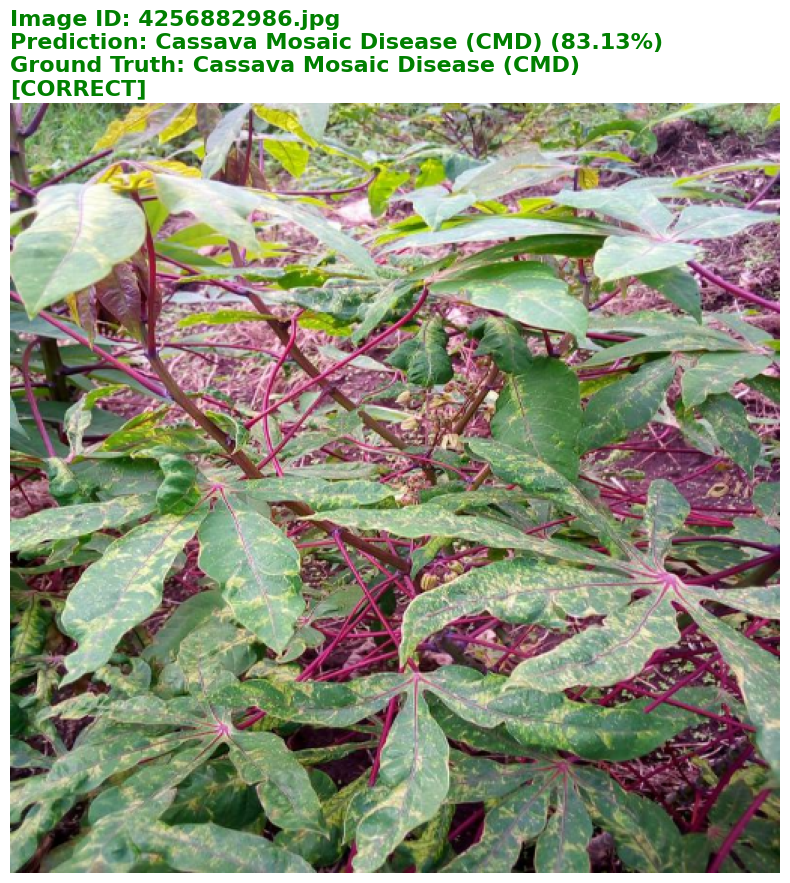

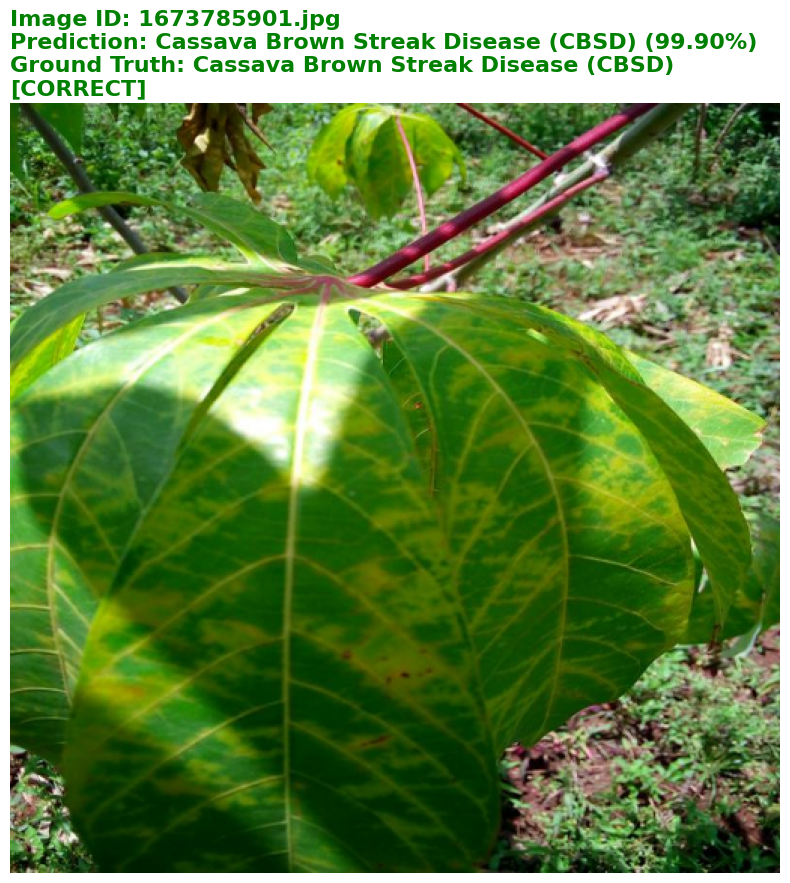

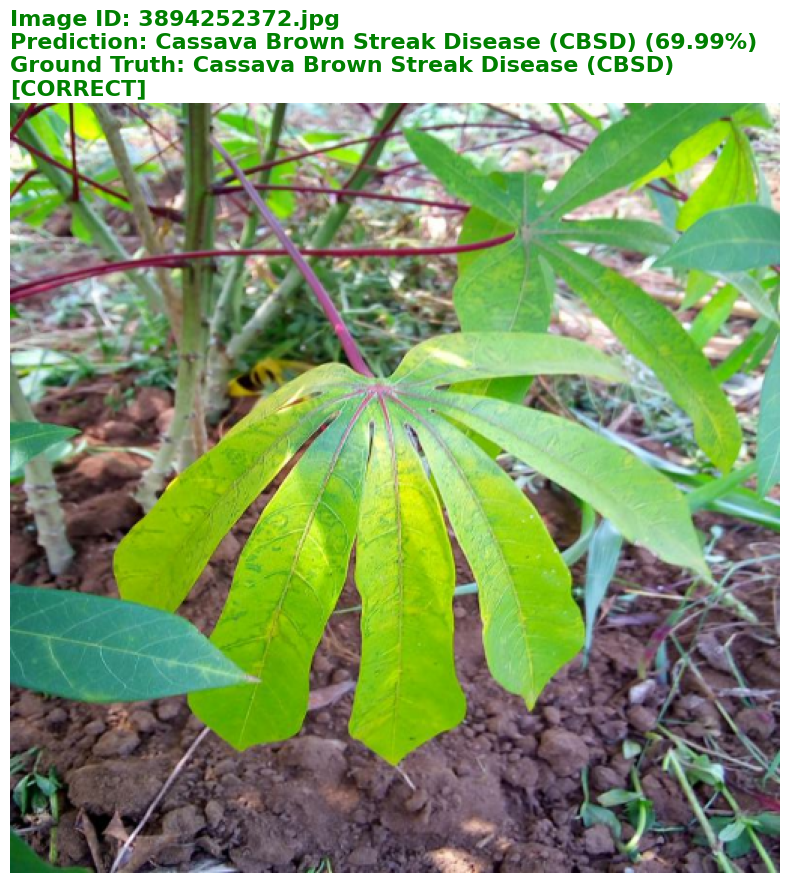

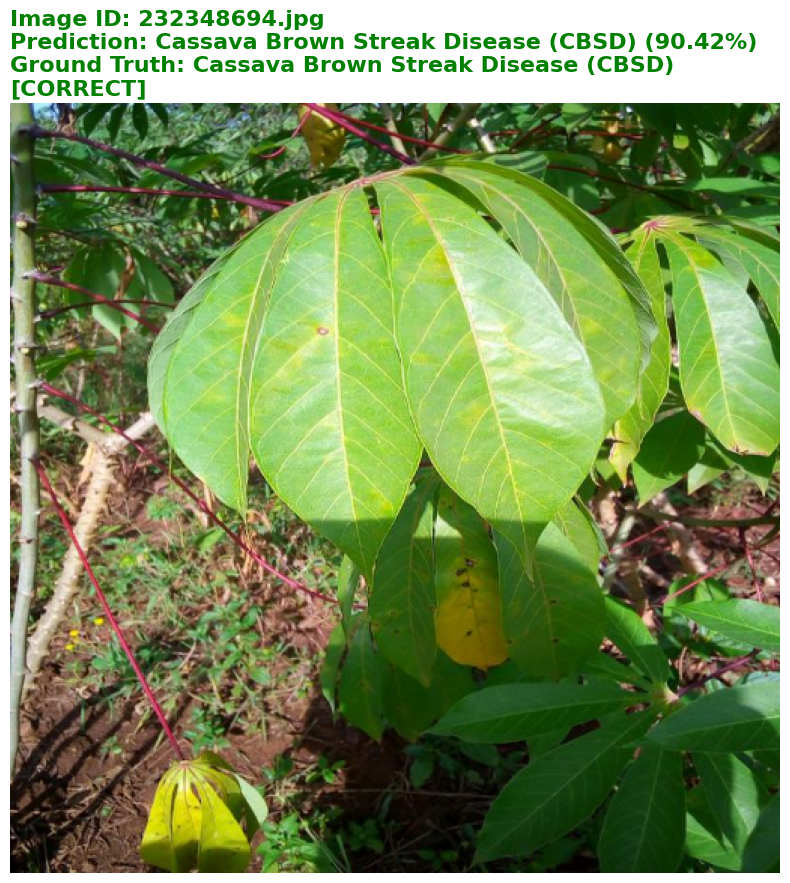

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Full Name Mapping for Cassava Leaf Diseases
LABEL_MAP = {
    0: "Cassava Bacterial Blight (CBB)",
    1: "Cassava Brown Streak Disease (CBSD)",
    2: "Cassava Green Mottle (CGM)",
    3: "Cassava Mosaic Disease (CMD)",
    4: "Healthy"
}

def check_model_on_train_images(num_samples=3, tta_runs=5):
    """
    Loads random images from train_images, runs your TTA function, 
    and compares predictions to ground truth with large visualizations.
    """
    # 1. Load the training CSV to get IDs and Labels
    train_csv_path = os.path.join(DATA_DIR, 'train.csv')
    train_df = pd.read_csv(train_csv_path)
    
    # 2. Sample random rows
    samples = train_df.sample(num_samples)
    
    # Lists to store batch data
    batch_images = []
    batch_ids = []
    ground_truths = []
    
    print(f"Loading {num_samples} training images for inference check...")
    
    # 3. Load and prepare images
    for idx, row in samples.iterrows():
        img_id = row['image_id']
        label = row['label']
        ground_truths.append(label)
        
        # Load image file
        img_path = os.path.join(DATA_DIR, 'train_images', img_id)
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMAGE_SIZE) 
        
        batch_images.append(img)
        batch_ids.append(img_id)

    # Convert to Tensor Batch
    batch_images = tf.stack(batch_images)
    batch_ids = tf.constant(batch_ids)

    # 4. Run Inference using YOUR defined TTA function
    print(f"Running TTA ({tta_runs} augmentations per image)...")
    preds, names = tta_predict_batch(model, batch_images, batch_ids, tta_runs)
    
    # 5. Visualize Results (Individual large plots)
    for i in range(num_samples):
        # Create a large figure for each image
        plt.figure(figsize=(10, 10))
        
        # Get labels and confidence
        pred_idx = np.argmax(preds[i])
        true_idx = ground_truths[i]
        confidence = preds[i][pred_idx]
        
        # Determine Color: Green if correct, Red if wrong
        color_code = 'green' if pred_idx == true_idx else 'red'
        status = "CORRECT" if pred_idx == true_idx else "WRONG"
        
        # Display image (normalized 0-1 for matplotlib)
        img_disp = batch_images[i].numpy() / 255.0
        plt.imshow(img_disp)
        
        # Create detailed title
        title_text = (
            f"Image ID: {batch_ids[i].numpy().decode('utf-8')}\n"
            f"Prediction: {LABEL_MAP[pred_idx]} ({confidence:.2%})\n"
            f"Ground Truth: {LABEL_MAP[true_idx]}\n"
            f"[{status}]"
        )
        
        plt.title(title_text, color=color_code, fontsize=16, fontweight='bold', loc='left')
        plt.axis("off")
        plt.show()

# --- Run the check ---
# I reduced num_samples to 3 so it doesn't clutter your notebook too much,
# but since they are individual plots, you can increase it if you like.
check_model_on_train_images(num_samples=6, tta_runs=5)

In [12]:
# Iterate through the test dataset and generate TTA predictions for each image
tta_num_augmentations = 10  # Number of augmented images to create per test image
tta_predictions = []
tta_image_names = []

for images, ids in test_dataset:
    # Run TTA for this *batch* (instead of each image individually)
    mean_preds, names = tta_predict_batch(model, images, ids, tta_num_augmentations)

    # Save results
    tta_predictions.extend(mean_preds)
    tta_image_names.extend(names)

I0000 00:00:1755627590.893080      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


## 📝 Create Submission File

Finally, we process our predictions and format them into a `submission.csv` file as required by the competition. We take the `argmax` of our averaged predictions to get the final predicted class label for each image.

In [13]:
tta_predictions = np.array(tta_predictions)
# Find the index of the highest probability for each prediction to get the final label
final_tta_labels = tf.argmax(tta_predictions, axis=1)
pred_labels = final_tta_labels.numpy()

In [14]:
# Create a new DataFrame with the correct order
submission_df = pd.DataFrame({
    'image_id': tta_image_names,
    'label': pred_labels
})

# Save the final submission file
submission_df.to_csv('submission.csv', index=False)

print('Submission file created successfully!')

Submission file created successfully!
